In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from MPCVelControl_D4_1 import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 0.05
sim_time = 30
H = 6.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="nonlinear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at itera

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=599, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x185a37bf770>,
 'scene_objects': {'rocket_actor': Actor (0x185a3ac5360)
    Center:                     (50.32007, 49.9984915, 100.58848449999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    4.936E+01, 5.128E+01
    Y Bounds                    4.879E+01, 5.121E+01
    Z Bo

In [4]:
t = np.array(mpc.slack_log["t"])
alpha0 = np.array(mpc.slack_log["alpha0"])
beta0  = np.array(mpc.slack_log["beta0"])

# eps is in radians -> choose threshold in radians
thr = np.deg2rad(0.05)  # 0.05 deg threshold

alpha_used = np.abs(alpha0) > thr
beta_used  = np.abs(beta0)  > thr

N = len(t)

alpha_active_pct = 100.0 * np.count_nonzero(alpha_used) / N
beta_active_pct  = 100.0 * np.count_nonzero(beta_used)  / N

print(f"alpha slack active: {alpha_active_pct:.1f}% of time")
print(f"beta  slack active: {beta_active_pct:.1f}% of time")

print("alpha max slack [deg]:", np.rad2deg(np.max(alpha0)))
print("beta  max slack [deg]:", np.rad2deg(np.max(beta0)))



alpha slack active: 1.0% of time
beta  slack active: 0.8% of time
alpha max slack [deg]: 1.0896377372046238
beta  max slack [deg]: 0.8615125444353763


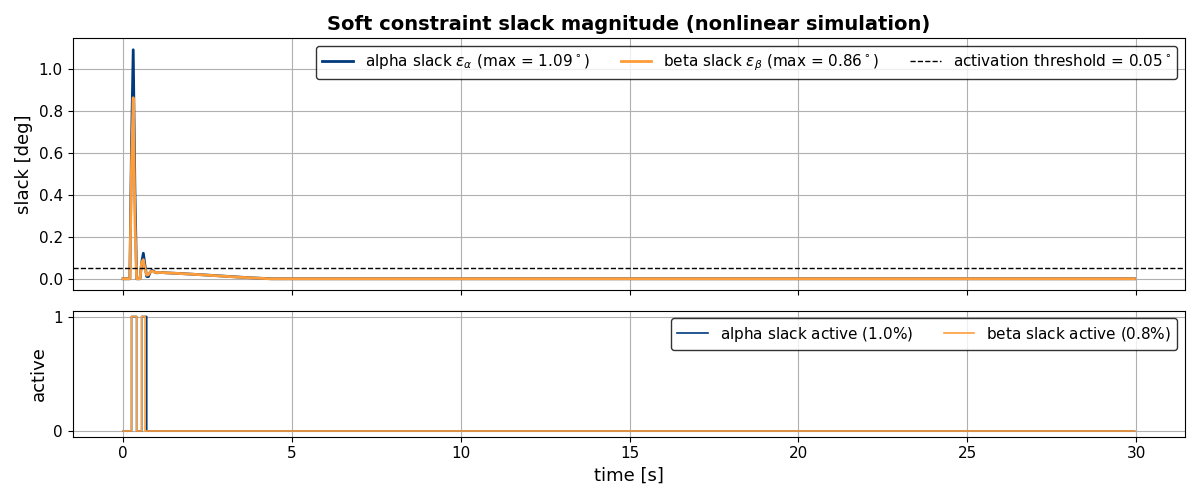

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from plot_style import set_mpc_style
set_mpc_style()

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11

alpha_deg = np.rad2deg(alpha0)
beta_deg  = np.rad2deg(beta0)
thr_deg   = np.rad2deg(thr)

fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}
)

# Top: slack magnitude

axs[0].plot(
    t, alpha_deg,
    label=fr"alpha slack $\epsilon_\alpha$ (max = {np.max(alpha_deg):.2f}$^\circ$)",
    linewidth=2
)
axs[0].plot(
    t, beta_deg,
    label=fr"beta slack $\epsilon_\beta$ (max = {np.max(beta_deg):.2f}$^\circ$)",
    linewidth=2
)
axs[0].axhline(
    thr_deg,
    linestyle="--",
    linewidth=1,
    color="black",
    label=fr"activation threshold = {thr_deg:.2f}$^\circ$"
)
axs[0].set_ylabel("slack [deg]",fontsize=LABEL_FONTSIZE)
axs[0].set_title("Soft constraint slack magnitude (nonlinear simulation)",fontsize=TITLE_FONTSIZE, fontweight="bold")
axs[0].tick_params(labelsize=TICK_FONTSIZE)
axs[0].grid(True)
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels, loc="upper right", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
)

# Bottom: activation

axs[1].step(
    t,
    alpha_used.astype(int),
    where="post",
    label=fr"alpha slack active ({alpha_active_pct:.1f}$\%$)"
)
axs[1].step(
    t,
    beta_used.astype(int),
    where="post",
    label=fr"beta slack active ({beta_active_pct:.1f}$\%$)"
)
axs[1].set_yticks([0, 1])
axs[1].set_ylabel("active",fontsize=LABEL_FONTSIZE)
axs[1].set_xlabel("time [s]",fontsize=LABEL_FONTSIZE)
axs[1].tick_params(labelsize=TICK_FONTSIZE)
axs[1].grid(True)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="upper right", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
)

plt.tight_layout()
# plt.savefig("slack_usage_over_time.pdf", bbox_inches="tight")
plt.show()



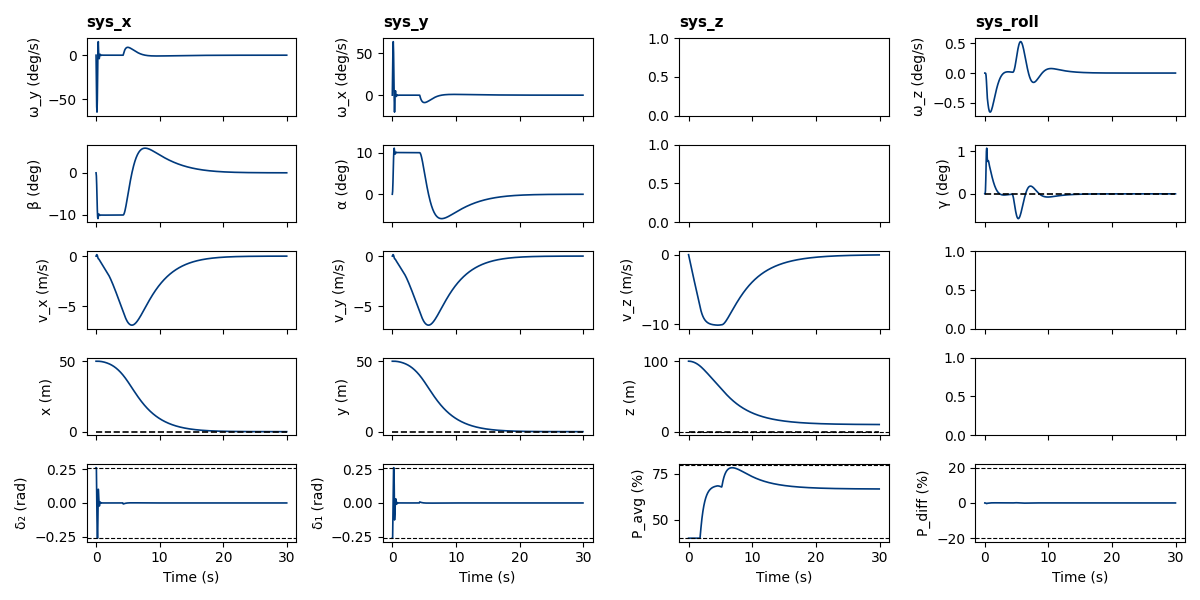

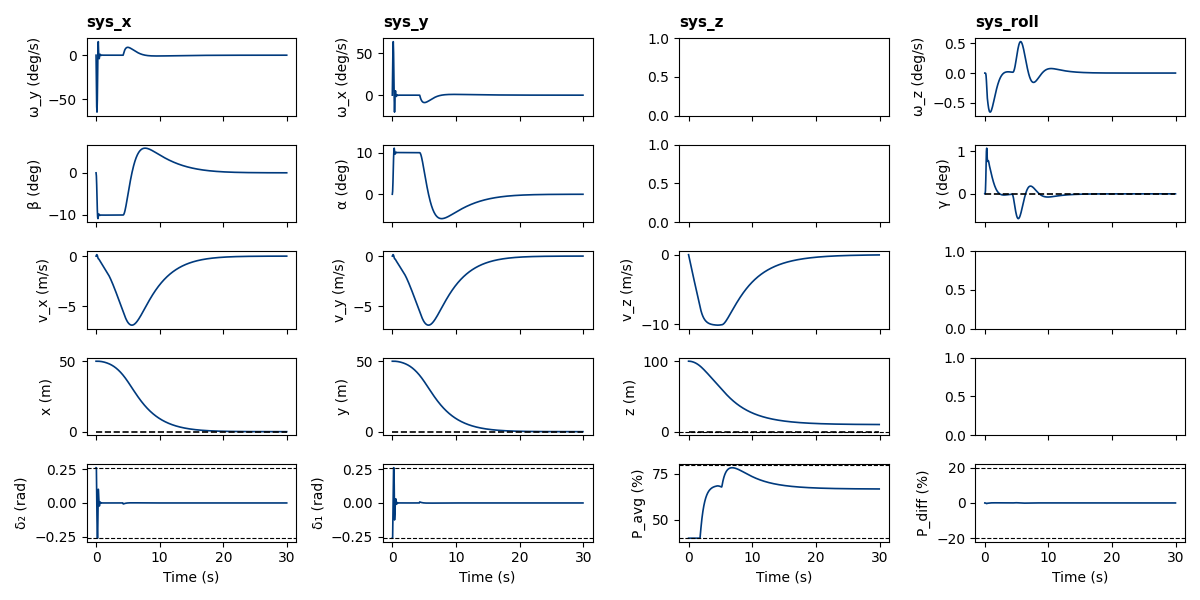

In [6]:
from src.vel_rocket_vis import plot_static_states_inputs
import matplotlib.pyplot as plt

T = t_cl[:-1]
X = x_cl[:, :-1]
U = u_cl
ref = ref[:,:-1]

plot_static_states_inputs(T, X, U, ref)
# plt.savefig("Non_lin_closedloop_states_inputs.pdf", bbox_inches="tight")
plt.show()

In [7]:
# Code below is used for comparison with Deliverble 5.1

In [8]:
Ts = 0.05
sim_time = 15; H = 6.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 1.5
rocket.fuel_rate = 0.0
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(mpc, sim_time, H, x0, x_target=x_target, method='nonlinear')


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at iteration 18
Maximum invariant set found after 19 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at 

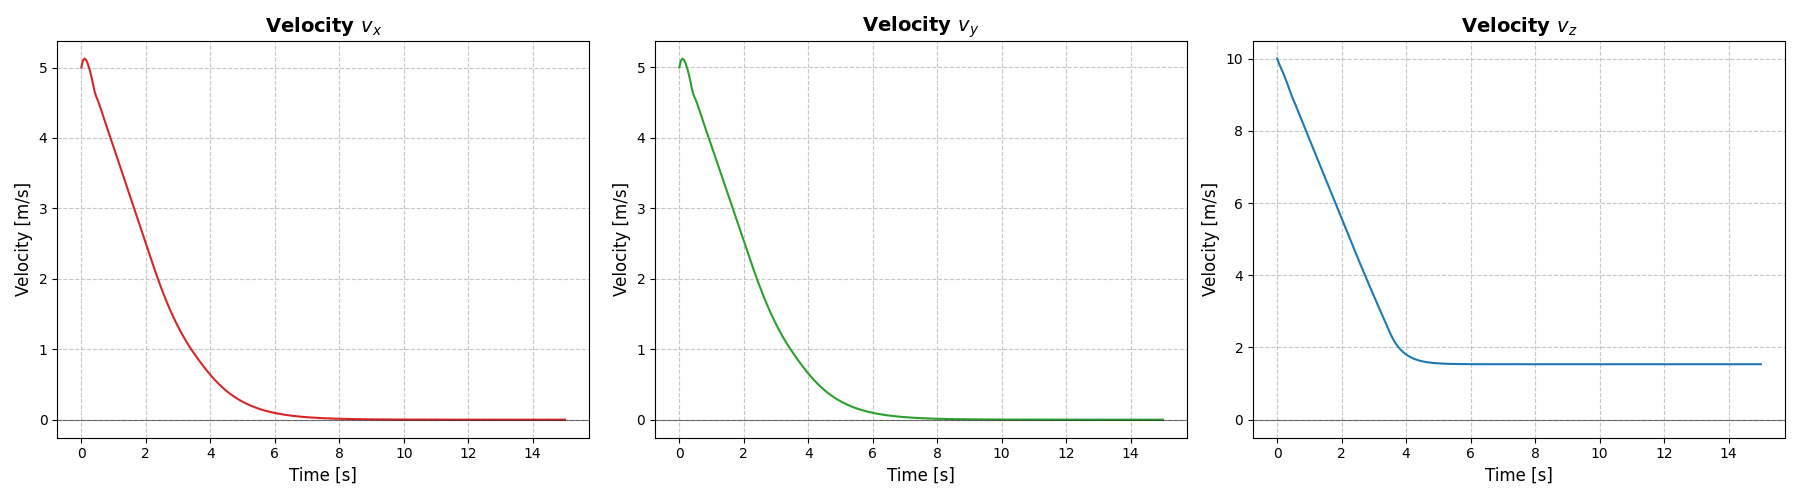

In [9]:
def plot_velocities_side_by_side(t_vector, x_trajectory):
    """
    Plots vx, vy, and vz velocities side-by-side.
    
    Args:
        t_vector: Time vector from simulation (t_cl)
        x_trajectory: Full state trajectory (12 x N matrix)
    """
    # Define indices for velocities: vx=6, vy=7, vz=8
    v_indices = [6, 7, 8]
    v_names = [r'$v_x$', r'$v_y$', r'$v_z$']
    v_colors = ['tab:red', 'tab:green', 'tab:blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, ax in enumerate(axes):
        idx = v_indices[i]
        ax.plot(t_vector, x_trajectory[idx, :], color=v_colors[i], linewidth=1.5)
        
        ax.set_title(f"Velocity {v_names[i]}", fontsize=14)
        ax.set_xlabel("Time [s]", fontsize=12)
        ax.set_ylabel("Velocity [m/s]", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add a horizontal line at 0 for reference
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

    plt.tight_layout()
    # plt.savefig("Vx_Vy_Vz_4.1.pdf", bbox_inches="tight")
    plt.show()

plot_velocities_side_by_side(t_cl, x_cl)